# <center>Tarea 1 - Introducción a las Redes Neuronales Artificiales</center>
## <center> Ariel Sanhueza - 201173005-4 </center>
## <center> Diego Pérez - 201173xxx-y </center>

### Previo
Primero importaremos las bibliotecas necesarias para desarrollar la tarea.

In [1]:
%matplotlib inline
import numpy as np

from numpy.random import rand
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

Using Theano backend.


## Problema 1

### a)
Primero generamos una función que genere $n$ pares (x,y), donde $x \in [-1,1]^2, y \in \{0,1\}$, como se sugirió en el enunciado.

In [2]:
def generate_data(n):
    # Generamos la matriz con los datos, de tamaño nx3
    ndata = 2*rand(n,3) - 1
    # Calculamos el valor que corresponde a y
    for i in range(n):
        if (ndata[i,0] > 0 and ndata[i,1] > 0) or (ndata[i,0] <= 0 and ndata[i,1] <= 0):
            ndata[i,2] = 0
        else:
            ndata[i,2] = 1
    return ndata

El problema se llama **XOR** pues la función de clasificación es la de la operación "OR-Exclusive". La separación sigue la misma lógica del XOR binario. Generamos los datos de entrenamiento y prueba para luego separarlos en la *data* de entrada y la data con los outputs deseados.

In [3]:
training_dt = generate_data(1000)
test_dt = generate_data(1000)

In [4]:
# Separamos la data en entrada y salida
X_training = training_dt[:,:2]
Y_training = training_dt[:,2]
X_test = test_dt[:,:2]
Y_test = test_dt[:,2]

### b)
Procedemos a generar neurona utilizando *keras* (como red neuronal de una capa oculta). Se mostrarán dos ejemplos donde se utilizarán dos funciones de activación: **lineal** y **sigmoidal**. Esto se hará para demostrar que independiente de los parámetros de la neurona, el problema no puede ser resuelto por ella. Los parámetros de la compilación son seteados de acuerdo a la página oficial de *keras* sobre un ejemplo de clasificador binario.

In [5]:
# Primero modelo
model_linear = Sequential()
model_linear.add(Dense(1, input_dim=2, activation='linear'))

In [6]:
# Compilamos
model_linear.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Entrenamos
model_linear.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 4.5273 - acc: 0.3490     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 1.9223 - acc: 0.4600     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.7491 - acc: 0.4850     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.7146 - acc: 0.4850     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.7018 - acc: 0.5290     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.6974 - acc: 0.4850     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.6947 - acc: 0.4960     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.6942 - acc: 0.3940     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.6939 - acc: 0.5000     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.6936 - acc: 0.5150     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0

In [8]:
# Evaluamos el modelo
scores_linear = model_linear.evaluate(X_test, Y_test)
print("\nPrecisión de clasificación: {0:.2f}%".format(scores_linear[1]*100))

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 46.90%


In [9]:
# Segundo modelo
model_sig = Sequential()
model_sig.add(Dense(1, input_dim=2, activation='linear'))

In [10]:
# Compilamos
model_sig.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Entrenamos
model_sig.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 4.6766 - acc: 0.2600     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 1.6237 - acc: 0.4420     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.7347 - acc: 0.3960     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.7086 - acc: 0.4440     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.6991 - acc: 0.5410     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.6963 - acc: 0.4770     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.6944 - acc: 0.6000     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.6935 - acc: 0.6110     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.6934 - acc: 0.6030     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.6936 - acc: 0.6240     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0

In [12]:
# Evaluamos el modelo
scores_sig = model_sig.evaluate(X_test, Y_test)
print("\nPrecisión de clasificación: {0:.2f}%".format(scores_sig[1]*100))

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 59.40%


Como se puede ver en ambos modelos, la precisión de clasificación en el conjunto de prueba es de aproximadamente un 50%. Esto se debe a que una sola neurona solo puede aproximar funciones lineales y por lo tanto solo puede resolver problemas linealmente separables. Dado que el problema **XOR** no es linealmente separable, utilizando una sola recta se tiene en aproximadamente un 50% de error teórico.

### c)
Ahora veremos para un modelo con 2 capas ocultas. La activación de las capas ocultas será una función sigmoidal. La capa de salida tendrá activación lineal.

In [52]:
# Creamos la red con sus parámetros
model_nn = Sequential()
model_nn.add(Dense(20, input_dim=2, activation='tanh'))
model_nn.add(Dense(1, activation='linear'))

In [53]:
# Compilamos
model_nn.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Entrenamos
model_nn.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 4.3537 - acc: 0.5990     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 1.2480 - acc: 0.4580     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.7056 - acc: 0.4490     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.6990 - acc: 0.4510     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.6952 - acc: 0.5030     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.6918 - acc: 0.5160     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.6898 - acc: 0.5210     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.6855 - acc: 0.5790     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.6834 - acc: 0.5460     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.6796 - acc: 0.5970     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0

In [55]:
# Evaluamos el modelo
scores_nn = model_nn.evaluate(X_test, Y_test)
print("\nPrecisión de clasificación: {0:.2f}%".format(scores_nn[1]*100))

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 95.00%


Como se puede ver en este experimento utilizando el modelo descrito la precisión en el set de prueba es de un 95% por lo que, dependiendo de los parámetros escogidos, el problema sí es resolvible mediante un perceptrón multicapas.

## Problema 2

### a)
Obtenemos los datos del link facilitado. Las líneas realizan:
* Línea 3: Se lee el CSV desde la URL entregada. Se marca el caracter ',' como separador de los datos y el parámetro names indica los nombres de cada columna.
* Línea 4: importa desde sklearn la función train_test_split que separa el dataset entre datos de entrenamiento y testing de forma aleatoria.
* Línea 5: Aplica train_test_split para separar en subconjuntos de entrenamiento y testeo.

In [4]:
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'

df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

### b)

In [3]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(9), int64(5)
memory usage: 55.4 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806
std,8.601545,23.310593,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000
75%,3.677082,12.000000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### c)
Cuando los datos vienen en escalas muy diferentes puede llevar a que los datos con escalas más grandes logren mayor peso frente a los de menor escala (por ejemplo a la hora de calcular distancias). Normalizar los datos permite que todos los datos tengan un aporte "igualitario" a la hora de entrenar la red.

In [5]:
# Datos de entrenamiento
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('MEDV')
# Datos de testing
scaler2 = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler2.transform(df_test),columns=df_test.columns)
y_test_scaled = X_test_scaled.pop('MEDV')

### d)

In [7]:
model2_sig = Sequential()
model2_sig.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model2_sig.add(Activation('sigmoid'))
model2_sig.add(Dense(1, init='uniform'))
model2_sig.add(Activation('linear'))

sgd_sig = SGD(lr=0.2)
model2_sig.compile(optimizer=sgd_sig,loss='mean_squared_error')

hist_sig = model2_sig.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 34311582312178218768007168.0000 - val_loss: 75177102402671549714003918848.0000
Epoch 2/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan                    
Epoch 3/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 4/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 5/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 6/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 7/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 8/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 9/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 10/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 11/300
3

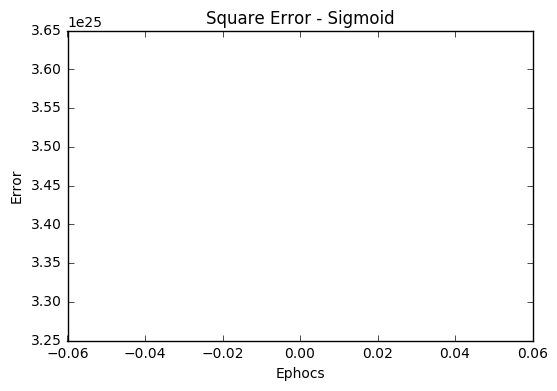

In [8]:
plt.plot(hist_sig.history['loss'])
plt.title('Square Error - Sigmoid')
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

Como se puede ver en el output generador, el método diverge con los parámetros entregados. El gráfico no muestra nada pues no se obtuvieron resultados.

### e)

In [9]:
model2_relu = Sequential()
model2_relu.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model2_relu.add(Activation('relu'))
model2_relu.add(Dense(1, init='uniform'))
model2_relu.add(Activation('linear'))

sgd_relu = SGD(lr=0.2)
model2_relu.compile(optimizer=sgd_relu,loss='mean_squared_error')

hist_relu = model2_relu.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 0.4660 - val_loss: 0.5563
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.1995 - val_loss: 0.3491
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.1756 - val_loss: 0.2932
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.1644 - val_loss: 0.3033
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.1347 - val_loss: 0.2759
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.1353 - val_loss: 0.3429
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.1216 - val_loss: 0.2475
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.1202 - val_loss: 0.3498
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.1185 - val_loss: 0.3329
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.1460 - val_loss: 0.2355
Epoch 11/300
379/379 [===========

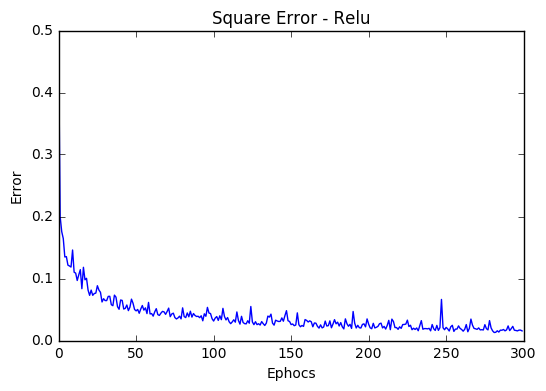

In [10]:
plt.plot(hist_relu.history['loss'])
plt.title("Square Error - Relu")
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

El gráfico muestra que a medida que aumenta el número de ephocs el error disminuye de manera asintótica.


### f)

In [31]:
# Generamos los n learning rates
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)

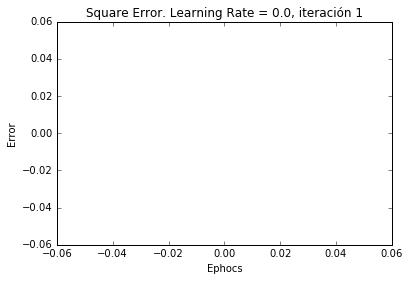

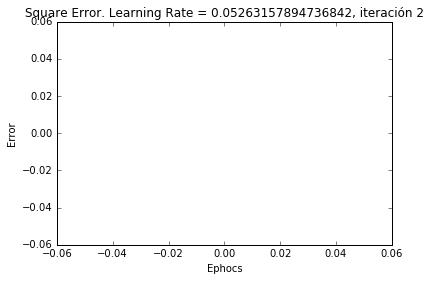

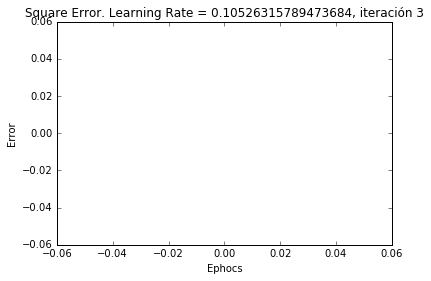

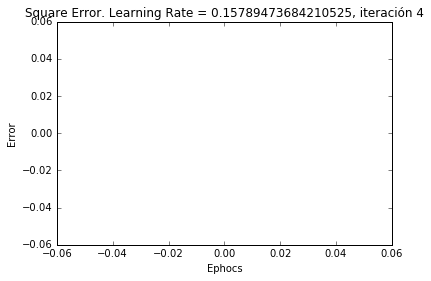

KeyboardInterrupt: 

In [32]:
i = 1
for rate in lear_rate:
    model_lr = Sequential()
    model_lr.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model_lr.add(Activation('sigmoid'))
    model_lr.add(Dense(1, init='uniform'))
    model_lr.add(Activation('linear'))

    sgd = SGD(lr=rate)
    model_lr.compile(optimizer='sgd',loss='mean_squared_error')

    hist_relu = model_lr.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    
    # Graficamos
    plt.plot(hist_relu.history['loss'])
    plt.title("Square Error. Learning Rate = {0}, iteración {1}".format(rate, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

In [68]:
lear_rate

array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
        0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
        0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
        0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ])